In [1]:
from src.loader import modelLoader
import cv2
import numpy as np

# loader = modelLoader('3A_ref')
# model = loader.modela

In [2]:
from src.loader import sampler
s = sampler('exp')

In [3]:
from src.tools import proceedPred
use = 47
out = proceedPred(s.get_npy(use), conf = 0.7, nms=True)
load = s[use]
out_poscar = load['position']

In [4]:
name = load['name']
print(name)

HDA_7_-1_1_1_1


## Find for Hup

In [5]:
from findpeaks import findpeaks
from src.tools import imgsPeak
lp5l = []
for i in [6,7]: # 10,13 for exp 17~20
    a = load['image'][i]
    lp5l.append(a)
    
fp = findpeaks(method='topology', denoise = 'fastnl',window=5, limit = 40, interpolate=10, imsize=(128,128))
r3 = imgsPeak(lp5l, fp, inverse=True, cluster_threshold = 5, border=7, show=False, flip=0)
# 因為有層間位移 所以這裡決定直接做位移修正
r1 = r3 + (-10,6,0)

## Find for left O

In [6]:
org06 = []
for i in range(0,3):
    img = load['image'][i]
    a = cv2.Laplacian(img.copy(),cv2.CV_16S,ksize=5)
    a[np.where(a > 0)] = 0
    a = -a
    a = cv2.convertScaleAbs(a)
    img_p = cv2.addWeighted(img, 0.95, a, 0.1, 0)
    org06.append(img_p)
fp = findpeaks(method='topology', denoise = 'lee_enhanced',window=7, limit = 5, interpolate=10, imsize=(128,128))
r2 = imgsPeak(org06, fp, inverse=False, cluster_threshold = 9, border=3, show=False, flip=0)

## Make Graph

In [7]:
from src.graph import Graph
g = Graph(load)

g.addAtoms("O", out["O"][...,:3])
g.addAtoms("H", out["H"][...,:3])

# if use reference
# g.addAtoms("O", load['position']['O'] @ load['info']['lattice'])
# g.addAtoms("H", load['position']['H'] @ load['info']['lattice'])

## Step : Generate missing Oxygen

In [8]:
import src.seelib.npmath as npmath
ref_img = load['image'][1]
reso = np.diag(np.asarray([25,25])/(128,128))
bg = np.zeros(ref_img.shape)
points = r2[...,:2].astype(np.uint8)
pos = points @ reso
for p, posi in zip(points,pos):
    mask = cv2.rectangle(bg, p -3, p +3, 1, -1)
    meanPixel = npmath.mask_mean(ref_img, mask)
    h = 3 - meanPixel/255 * 2
    posi = np.asarray([posi[0],posi[1],h])
    ind = g.addAtom("O", posi)
    oindex, opos = g.nearNodes(ind, elem = "O")[0]
    if opos < 2.2:
        g.remove_node(ind)

## Step  : H: find for the nearest O and correct self direction

In [9]:
onodes = g.get_nodes_by_attributes("elem", "O")
hnodes = g.get_nodes_by_attributes("elem", "H")

for hindex in hnodes:
    oindex, opos = g.nearNodes(hindex, elem = "O")[0]
    if opos > 1.3:
        oindex, opos = g.nearNodes(hindex, elem = "O")[1]
        if opos > 2.4:
            g.remove_node(hindex)
            continue
    Onext = list(g.neighbors(oindex))
    g.ppNode(oindex, hindex, 0.9584)
    if all(np.linalg.norm(g.nodes[i]['position'] - g.nodes[hindex]['position']) > 0.9 for i in Onext):
        g.linkAtom(oindex,hindex)
    else:
        g.remove_node(hindex)


## Step : Link all bond

In [10]:
ono = g.get_nodes_by_attributes("elem", "O")
g.linkAtoms(ono, ono)

## Step : link H to OObond

In [11]:
hnodes = g.get_nodes_by_attributes("elem", "H")
for hind in hnodes:
    g.linkH2B(hind)

## Step: Match all H-up to Oxygen

In [12]:
hpos = r1.copy()
hpos[...,2] = 2.7
hpos[...,:2] = hpos[...,:2] @ reso
for posi in hpos:
    ind = g.addAtom('H', posi, Hup = True)
    Onext = g.nearNodes(ind, elem = "O")
    Hnext = g.nearNodes(ind, elem = "H")
    for Hind, Hpos in Hnext:
        if Hpos > 1:
            continue
        else:
            g.nodes[Hind]['Hup'] = True
            g.remove_node(ind)
            break
    else:
        for Oind, Opos in Onext:
            if Opos > 2:
                g.remove_node(ind)
                break
            else:
                g.ppNode(Oind, ind, 0.9584)
                Hind, Hpos = g.nearNodes(ind, elem = "H")[0]
                if len(g.nodes[Oind]['bond']) >= 2 or Hpos < 0.5:
                    g.nodes[Hind]['Hup'] = True
                    g.remove_node(ind)
                    break
                else:
                    g.linkAtom(ind, Oind)
                    g.linkH2B(ind)
                    break
            

## Using solver to generate atoms

In [13]:
from src.solver import graphSolver
gs = graphSolver(g)
gs.switch_solver()
gs.edge_solver()
gs.switch_solver()
gs.edge_solver()
gs.switch_solver()
gs.edge_solver()
gs.switch_solver()
gs.tri_solver()
gs.tri_solver()
gs.adder_solver()
gs.remain_solver()
gs.HH_destroyer()
gs.adder_solver()
gs.remain_solver()
gs.adder_solver()
gs.remain_solver()

## 標記atoms ( H-up )

In [14]:
hupnode = g.get_nodes_by_attributes("Hup", True)
onlinknode = g.get_nodes_by_attributes("elem", keyword="H")
sel = []
for ind in onlinknode:
    if g.nodes[ind]['onLink'] is not None:
        sel.append(ind)
for ind in hupnode:
    g.nodes[ind]['color'] = (255,220,255)

## Plot all the Atoms and Edges

In [15]:
import matplotlib.pyplot as plt
out_img = g.plotEdges(3, transparency=0.5, text=False)
out_img = g.plotNodes(out_img)

In [16]:
from src.tools import drawFindPeaksResult
if True:
    out_img = drawFindPeaksResult(out_img, r1, mirror=True)
    

## Show results

True

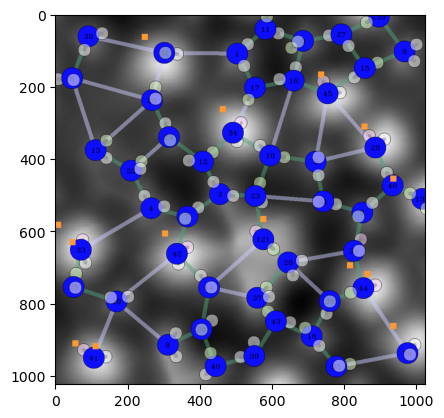

In [17]:
imgplot = plt.imshow(out_img)
cv2.imwrite("test.png", out_img)

In [18]:
g.save(f"/home/supercgor/gitfile/AFM-RepairTool/result/{name}.poscar")

In [19]:
gs.remain_solver()